## Analyze A/B Test Results
> By Soumia Zohra El Mestari



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, an A/B test will be run by an e-commerce website in order  to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` First, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.  Find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df[df['converted']== 1].shape[0]/ df.shape[0]


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df1 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')") 
df1.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> No missing values 

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  


In [8]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')") 

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** to get more informations about the dataset.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(['user_id'],keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. Commenting  the results in the previous two portions.

>**Answer:** <br>
 We can notice that the control group converted with higher rate than the treatment group but this difference is small (~ 0.02 ).
And given the probability of an individual to receive the new page is 0.5 ;this means we can't really tell that if one page led to move conversions than the other one .  

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we define our parameters : <br> 
Type I error rate of 5% 

> **Answer :** <br>
**$H_{0}$** : "**$p_{new}$**≤ **$p_{old}$** "<br>
**$H_{1}$** : " **$p_{new}$**> **$p_{old}$**"
    

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new_H0 = df2['converted'].mean()
print('convert rate of Pnew under H0 = {}'.format(p_new_H0))

convert rate of Pnew under H0 = 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old_H0 = df2['converted'].mean()
print('convert rate of Pold under H0 = {}'.format(p_old_H0))

convert rate of Pold under H0 = 0.11959708724499628


c. What is $n_{new}$?

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
print('Nnew = {}'.format(n_new))

Nnew = 145310


d. What is $n_{old}$?

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
print('Nold = {}'.format(n_old))

Nold = 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(n_new,p_new_H0)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(n_old,p_old_H0)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_H0_diff = new_page_converted/n_new - old_page_converted/n_old
print('pnew - pold = {}'.format(p_H0_diff))

pnew - pold = 0.0010713764015981564


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new_H0)
    old_page_converted = np.random.binomial(n_old, p_old_H0)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

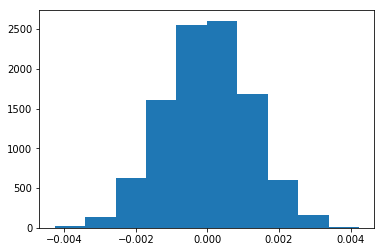

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
actual_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print('actual diffrence observed in the dataset = {}'.format(actual_diff))
p_diffs = np.array(p_diffs)
print('the proportion of the p_diffs are greater than the actual difference observed in the dataset is :')
(actual_diff < p_diffs).mean()

actual diffrence observed in the dataset = -0.0015782389853555567
the proportion of the p_diffs are greater than the actual difference observed in the dataset is :


0.90429999999999999

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **Answer :** <br> 
This value is called : the p_value <br>
The p_value is the probability of observing our statistic (result ) or more extreme results if the null hypothesis (**$H_{0}$** ) is true. <br> 
**How to intrepret this p_value ?** : <br>
1-   A large p_value means that our result ( statistic ) was more likely to come from $H_{0}$ which means we don't have evidence(we fail) to reject $H_{0}$ ( $H_{0}$:  suggests that  the new page conversion rate is higher than the old rate) <br>
2- Respectively a small p_value means that our result is more likely to have from another distribution than the null => we have strong evidence to reject the null hypothesis <=> "The new page convertion rate is higher than the old page conversion rate .

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Now we will calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]
print('The number of those who converted from the old_page = {}'.format(convert_old))
print('The number of those who converted from the new page = {}'.format(convert_new))
print('The number of individuals in the control group = {}'.format(n_old))
print('The number of individuals in the treatment group = {}'.format(n_new))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The number of those who converted from the old_page = 17489
The number of those who converted from the new page = 17264
The number of individuals in the control group = 145274
The number of individuals in the treatment group = 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('zScore = {}'.format(z_score))
print('p_value = {}'.format( p_value))

zScore = 1.3109241984234394
p_value = 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> **Answer** : <br>"
1- Z scores are measures of standard deviation so given zScore = 1.31 means we are 1.31 standard deviations away from the mean.<br>
2- the critical Z_score values when using a 95% confidence(error rate of 5%)  level are -1.96 and +1.96 standard deviations. => our z_score is not equal to one of these values 
<br>
3- We have a large p_value of 0.905 <br>
We have evidence that our result is likely to come from $H_{0}$ => 

**Conclusion** : we fail to reject $H_{0}$ and yes these findings agree with what I found in parts j and k.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **Answer :** I should perform a logistic regresion in this case

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
#we drop the second dummy variable t make sure we get a full rank matrix 
df2.drop('control',axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:53:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  

> **Answer:** <br>
p_value(ab_page ) = 0.190 <br> 
The new hypothesis under this regression model : $H_{0}$ : "$P_{new}$ = $P_{old}$" and $H_{1}$ :"$P_{new}$  ≠ $P_{old}$" <br>
In this regression model we are testing from two sides($P_{new}$ = $P_{old}$)  while in Part two we were testing from one side only ($P_{new}$ <= $P_{old}$)


f. Now, we are considering other things that might influence whether or not an individual converts.  Are there any disadvantages to adding additional terms into your regression model?

>**Answer**<br>
1- We would like to know more about the clients ( the idividuals ) things like their ages , genders , which programs are they applying for ... this kind or informations may have a significant influence in the user decision and therefore adding them may help our model to perform better.It is also a good idea to look for trends that appear in groups and disappear when these groups are aggregated ('Simpson's paradox').<br>
2- Yes if we add high correlations predictor variables we will end up getting unreliable and unstable estimates of regression coefficients due to the Multicollinearity this can highly affect our model.Every time we include a new predictor variable with no change in sample size we end up having results showing that the significant predictor variables that we had previously are no longer significant.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns 

In [33]:
df_countries = pd.read_csv('./countries.csv')
df3= df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [34]:
# the intercept exists already so we need to create the dummy variables for the country column
#first we get all the unique values of the country column
df3['country'].unique()


array(['UK', 'US', 'CA'], dtype=object)

In [35]:
#second we create the dummy variables
df3[['UK','US','CA']] = pd.get_dummies(df3['country'])
#third we get rid of one of these variables to make sure we get a full rank matrix
# here I chose to drop the US column
df3.drop('US',axis=1,inplace=True)


In [36]:
#HERE ARE THE RESULTS
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [43]:
# we create the interactions  
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['CA_ab_page'] = df3['CA']*df3['ab_page']

# Now we create and fit our model
model = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'CA','ab_page','UK_ab_page','CA_ab_page']])
resu = model.fit()

resu.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Dec 2018   Pseudo R-squ.:               3.482e-05
Time:                        21:18:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
UK            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
UK_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
CA_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In [40]:
np.exp(resu.params)

intercept     0.136392
UK            0.988285
CA            1.005761
ab_page       1.010893
UK_ab_page    0.924703
CA_ab_page    0.969090
dtype: float64

In [39]:
1/np.exp(resu.params)

intercept     7.331806
UK            1.011854
CA            0.994272
ab_page       0.989224
UK_ab_page    1.081428
CA_ab_page    1.031896
dtype: float64

**Conclusions** <br>
All p_values are greater than 0.05 which means that their correspondent variables don't have significant effect; and therefore we fail to reject $H_{0}$ ; we don't have a sufficient evidence that the interaction between the user's country and the page that he/she received will lead him /her to convert or not .
<br>
From these results we can say that we don't have enough informations to suggest that the new page leads to more conversions than the old one.
<br> 
We can't launch this new page based on this study ; I suggest to investigate deeper:<br>
1- for example to take a look at the duration of this experiment ; and make sure to run it during a sufficient period .<br>
2- Check for possible imbalances in the population represented in each group which can lead to situations like Simpson's paradox.<br>
3-Consider taking a look at the types of our users ( new user /old user ) to identify possible change aversion situation ( where the old users just don't like the change => try running the experiment longer to avoid this biased behaviour).